# Protected CRR

In [1]:
import os
n_cores = 5
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp.martingale import PluginMartingale, SimpleJumper
from scipy.optimize import brentq
from tqdm.notebook import tqdm
from online_cp import ConformalRidgeRegressor

from online_cp.evaluation import Evaluation, WinklerScore, Err, Width

from sklearn.datasets import fetch_california_housing

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2024)

kernel = 'gaussian'
min_sample_size = 100
window_size = None

In [2]:
number_of_examples = 6000
housing = fetch_california_housing()
X = housing['data'][:number_of_examples]
Y = housing['target'][:number_of_examples]

In [3]:
epsilon = 0.1

eps = epsilon
bounds = 'both'

cp = ConformalRidgeRegressor(a=0, studentised=True)

# Ensure that we can get informative prediction sets from the start
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = Y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = Y[int(np.ceil(2/epsilon)):]

cp.learn_initial_training_set(X_init_train, y_init_train)

martingale = PluginMartingale(kernel=kernel, warnings=False, window_size=window_size, min_sample_size=min_sample_size)
# martingale = SimpleJumper(warnings=False)

p_values = np.empty_like(y_process)
protected_p_values = np.empty_like(y_process)

base_predictions = np.empty(shape=(y_process.shape[0], 2))
protected_predictions = np.empty(shape=(y_process.shape[0], 2))

epsilon_hat_array = np.empty_like(y_process)

base_efficiency = Evaluation(err=Err, winkler=WinklerScore, width=Width)
protected_efficiency = Evaluation(err=Err, winkler=WinklerScore, width=Width)

for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), total=y_process.size):

    # Base prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True, bounds=bounds)
    base_predictions[i, :] = (Gamma.lower, Gamma.upper)

    # Protected prediction
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)

    protected_Gamma = cp.predict(obj, epsilon=epsilon_hat, bounds=bounds)
    protected_predictions[i, :] = (protected_Gamma.lower, protected_Gamma.upper)
    epsilon_hat_array[i] = epsilon_hat

    # Compute p-values
    p = cp.compute_p_value(x=obj, y=lab, precomputed=precomputed, bounds=bounds, smoothed=False)
    protected_p = martingale.B_n(p)

    base_efficiency.update(y=lab, Gamma=Gamma, epsilon=epsilon)
    protected_efficiency.update(y=lab, Gamma=protected_Gamma, epsilon=epsilon)

    martingale.update_martingale_value(p)

    p_values[i] = p
    protected_p_values[i] = protected_p

    cp.learn_one(obj, lab)

  0%|          | 0/5980 [00:00<?, ?it/s]

In [4]:
Losses = {}
for window_size in [50, 100, 200, 250, 300, 500, 1000, 'adaptive', None]:    
    M = PluginMartingale(kernel=kernel, warnings=False, window_size=window_size, min_sample_size=100)
    Loss = 0
    for p in p_values:
        Loss += -np.log(M.b_n(p))
        M.update_martingale_value(p)
    Losses[window_size] = Loss

In [5]:
for size, loss in Losses.items():
    print(str(size) + ':',Losses[size] / p_values.size)

50: -0.06580340764669419
100: -0.05112387618530842
200: -0.027026986180405825
250: -0.022753660563675615
300: -0.022389717628467955
500: -0.016710118842623394
1000: -0.018891176960850263
adaptive: -0.04221319094378043
None: -0.019165054998037792


In [6]:
base_efficiency.summarize()

{'err': {'mean': 0.16638795986622074,
  'std': 0.3724285255962245,
  'min': 0,
  'max': 1,
  'last': 0},
 'winkler': {'mean': 3.66412140477274,
  'std': 18.852989416464897,
  'min': 1.2940167183971498,
  'max': 1394.6932094587828,
  'last': 2.342699146727124},
 'width': {'mean': 1.8251679961140836,
  'std': 0.38544971968038777,
  'min': 1.2940167183971498,
  'max': 22.372459648895486,
  'last': 2.342699146727124}}

In [7]:
protected_efficiency.summarize()

{'err': {'mean': 0.14180602006688964,
  'std': 0.3488510753024542,
  'min': 0,
  'max': 1,
  'last': 0},
 'winkler': {'mean': 3.5202417179509955,
  'std': 18.356307528832946,
  'min': 1.2257290509945056,
  'max': 1368.8138412340625,
  'last': 2.709278962287555},
 'width': {'mean': 1.992037651636811,
  'std': 0.5005699594868098,
  'min': 1.2257290509945056,
  'max': 24.408011190270855,
  'last': 2.709278962287555}}

Text(0.5, 1.0, 'Protected CRR')

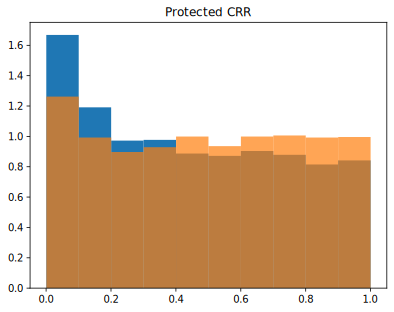

In [8]:
protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.title('Protected CRR')

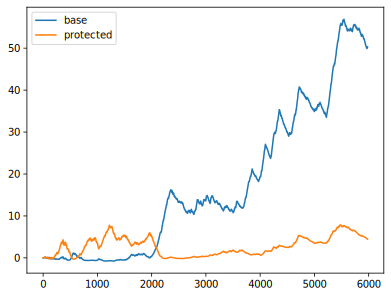

In [9]:
calibration_martingale = PluginMartingale(kernel=kernel, warnings=False, window_size=window_size, min_sample_size=min_sample_size) 
# calibration_martingale = SimpleJumper(warnings=False)
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(martingale.log10_martingale_values, label='base')
plt.plot(calibration_martingale.log10_martingale_values, label='protected')
plt.legend()

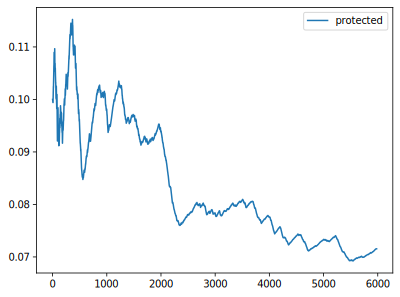

In [10]:
plt.plot(epsilon_hat_array, label='protected')
plt.legend()
# plt.savefig('ACI_vs_protection.pdf')

In [11]:
epsilon_hat_array.max(), epsilon_hat_array.min()

(0.11523617183629224, 0.06924898866535474)

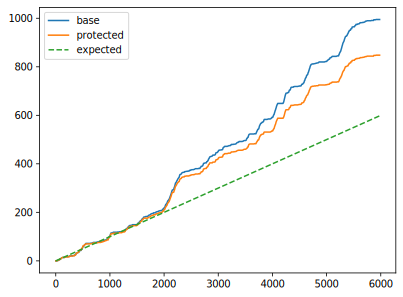

In [12]:
plt.plot(np.cumsum(((base_predictions[:,0] > y_process) + (base_predictions[:, 1] < y_process)).astype(int)), label='base')
plt.plot(np.cumsum(((protected_predictions[:,0] > y_process) + (protected_predictions[:, 1] < y_process)).astype(int)), label='protected')
plt.plot(epsilon*np.array([i for i,_ in enumerate(y_process)]), label='expected', linestyle='--')
plt.legend()

In [13]:
def compute_Err(p_values, epsilon):
    return (p_values <= epsilon).mean()

eps = epsilon

delta = 0.01
M = p_values.size
gamma_opt = (max(epsilon, 1-epsilon))/(delta*M - 1)
gamma = gamma_opt
gamma = 0.05
err = 0

Epsilon = np.array([i/1000 for i in range(1000)])
calibration_array = np.zeros(shape=(Epsilon.size, 3))
for i, epsilon in tqdm(enumerate(Epsilon), total=Epsilon.size):
    calibration_array[i, 0] = compute_Err(p_values, epsilon)
    calibration_array[i, 1] = compute_Err(protected_p_values, epsilon)

  0%|          | 0/1000 [00:00<?, ?it/s]

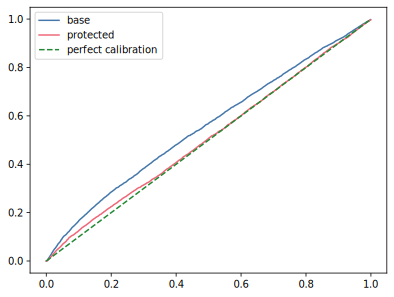

In [14]:
plt.plot(
    Epsilon, 
    calibration_array[:, 0],
    label='base',
    color=cmap[0]
)
plt.plot(
    Epsilon, 
    calibration_array[:, 1],
    label='protected', 
    color=cmap[1]
)
plt.plot(
    Epsilon,
    Epsilon,
    label='perfect calibration',
    linestyle='--', 
    color=cmap[2]
)
plt.legend()

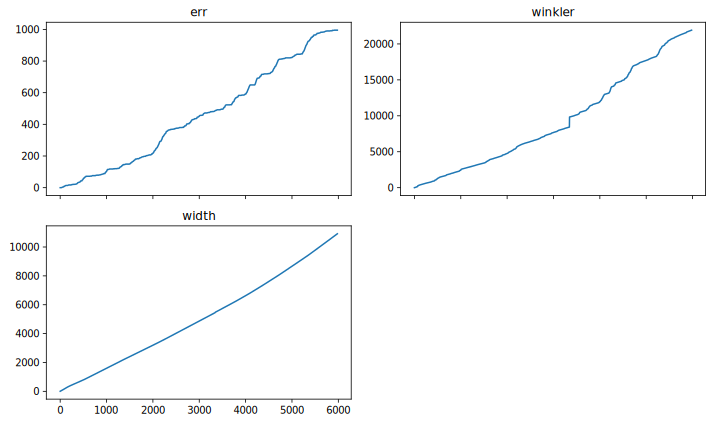

In [15]:
base_efficiency.plot_cumulative_results()

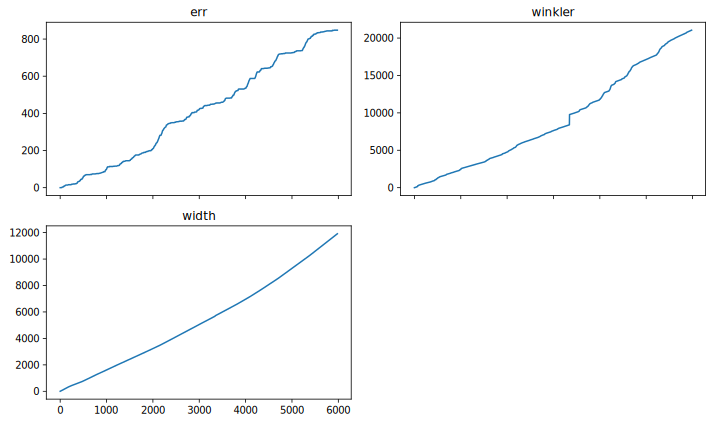

In [16]:
protected_efficiency.plot_cumulative_results()

Text(0.5, 1.0, 'Winkler score')

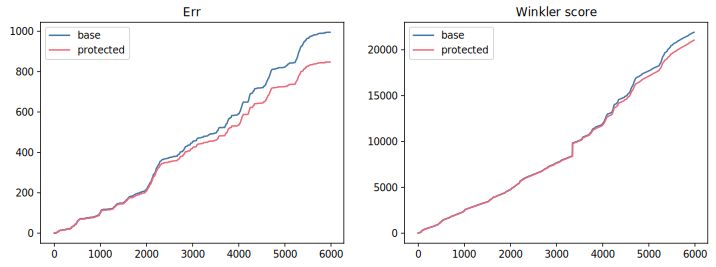

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

axs[0].plot(np.cumsum(((base_predictions[:,0] > y_process) + (base_predictions[:, 1] < y_process)).astype(int)), label='base', color=cmap[0])
axs[0].plot(np.cumsum(((protected_predictions[:,0] > y_process) + (protected_predictions[:, 1] < y_process)).astype(int)), label='protected', color=cmap[1])
axs[0].legend()
axs[0].set_title('Err')

axs[1].plot(base_efficiency.cumulative('winkler'), label='base', color=cmap[0])
axs[1].plot(protected_efficiency.cumulative('winkler'), label='protected', color=cmap[1])
axs[1].legend()
axs[1].set_title('Winkler score')

# fig.savefig('synthetic_regression.pdf')

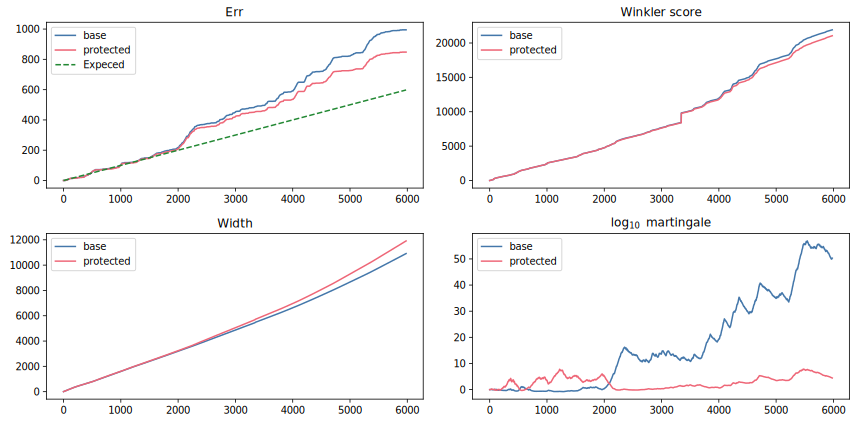

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))

axs[0,0].plot(np.cumsum(base_efficiency.results['err']), label='base', color=cmap[0])
axs[0,0].plot(np.cumsum(protected_efficiency.results['err']), label='protected', color=cmap[1])
axs[0,0].plot(list(0.1*i for i in range(base_predictions.shape[0])), linestyle='--', label='Expeced', color=cmap[2])
axs[0,0].legend()
axs[0,0].set_title('Err')

axs[0,1].plot(base_efficiency.cumulative('winkler'), label='base', color=cmap[0])
axs[0,1].plot(protected_efficiency.cumulative('winkler'), label='protected', color=cmap[1])
axs[0,1].legend()
axs[0,1].set_title('Winkler score')

axs[1,0].plot(np.cumsum(base_efficiency.results['width']), label='base', color=cmap[0])
axs[1,0].plot(np.cumsum(protected_efficiency.results['width']), label='protected', color=cmap[1])
axs[1,0].set_title('Width')
axs[1,0].legend()

axs[1,1].plot(martingale.log10_martingale_values, label='base', color=cmap[0])
axs[1,1].plot(calibration_martingale.log10_martingale_values, label='protected', color=cmap[1])
axs[1,1].set_title(r'$\log_{10}$ martingale')
axs[1,1].legend()
fig.tight_layout()

fig.savefig(f'../data/data_protected_conformal_classification/plots_copa/housing_epsilon_{0.1}.pdf')

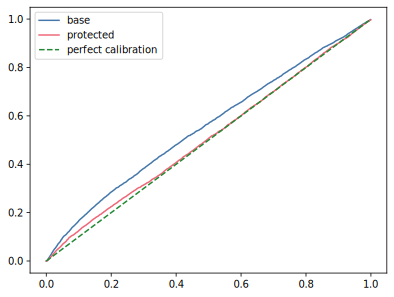

In [19]:
fig, ax = plt.subplots()
ax.plot(
    Epsilon, 
    calibration_array[:, 0],
    label='base',
    color=cmap[0]
)
ax.plot(
    Epsilon, 
    calibration_array[:, 1],
    label='protected', 
    color=cmap[1]
)
ax.plot(
    Epsilon,
    Epsilon,
    label='perfect calibration',
    linestyle='--', 
    color=cmap[2]
)
ax.legend()
fig.savefig(f'../data/data_protected_conformal_classification/plots_copa/housing_calibration.pdf')